In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from database.connection import get_db_manager

In [2]:
# FILTROS BASE DE DATOS
TABLE_TYPE = 'domestic'  # 'domestic' o 'european'
LEAGUES = [      # Lista de ligas a incluir
    'ESP-La Liga'
]
SEASON = '2425'       # Temporada específica (ej: '2425', '2324')
POSITION_FILTER = 'MF'   # 'GK', 'DF', 'MF', 'FW' - primera posición (ej: 'MF')
MIN_MINUTES = 800        # Minutos mínimos (ej: 800)

# JUGADORES A ANALIZAR
PLAYER_1_SEARCH = 'Pedri'      # Nombre jugador 1 (ej: 'Pedri')
PLAYER_2_SEARCH = 'Bellingham' # Nombre jugador 2 (ej: 'Bellingham')

# CONFIGURACIÓN RADAR
RADAR_TITLE = "El Clásico Midfield"              # Título (ej: "Centre Mid Template")
RADAR_DESCRIPTION = "Pedri vs Bellingham - La Liga 24/25 (800+ mins)"        # Descripción (ej: "vs Top-5 League MF (800+ mins) 2024/25")
TEAM_COLORS = ['#004D98', '#FFFFFF']      # Colores (ej: ['#004D98', '#FFFFFF'])
SAVE_PATH_BASE = "images/pedri_bellingham_laliga"    # Ruta base (ej: "images/comparison")

print(f"Config: {len(LEAGUES)} ligas, temporada {SEASON}, pos '{POSITION_FILTER}', min {MIN_MINUTES} min")

Config: 1 ligas, temporada 2425, pos 'MF', min 800 min


In [3]:
# Conexión BD
db = get_db_manager()

# Query dinámico
table_suffix = TABLE_TYPE
league_list_str = "', '".join(LEAGUES)

# Construir columnas según tipo de tabla
if TABLE_TYPE == 'domestic':
    metrics_cols = "fbref_metrics, understat_metrics"
    league_col = "league"
else:
    metrics_cols = "fbref_metrics"
    league_col = "competition"

query_template = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    {league_col},
    season,
    position,
    nationality,
    age,
    {metrics_cols}
FROM footballdecoded.players_{table_suffix} p
WHERE p.{league_col} IN ('{league_list_str}')
AND p.season = '{SEASON}'
ORDER BY p.{league_col}, p.season DESC, p.team, p.player_name
"""

df_raw = pd.read_sql(query_template, db.engine)
db.close()

print(f"Extraídos: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")
df_raw.head()

Extraídos: 588 registros, 10 columnas


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,db4452eac2b4de06,Abdel Abqar,Alavés,ESP-La Liga,2425,DF,MAR,25.0,"{'FK': '0', 'OG': '0', 'Crs': '5', 'Fld': '31'...","{'understat_xa': '0.23812325112521648', 'under..."
1,8820f1f696b5126b,Abderrahman Rebbach,Alavés,ESP-La Liga,2425,"FW,MF",ALG,25.0,"{'FK': '0', 'OG': '0', 'Crs': '17', 'Fld': '6'...","{'understat_xa': '0.27545187063515186', 'under..."
2,a3463ccf35649c59,Adrian Rodriguez,Alavés,ESP-La Liga,2425,GK,ESP,23.0,"{'CS': '1', 'FK': '0', 'OG': '0', '/90': '-0.3...","{'understat_xa': '0.35549480095505714', 'under..."
3,c16ef47f7c6492a7,Aleksandar Sedlar,Alavés,ESP-La Liga,2425,DF,SRB,32.0,"{'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '5',...","{'understat_xa': '0.0', 'understat_team': 'Ala..."
4,a9c5ac8ef2ca1ac3,Ander Guevara,Alavés,ESP-La Liga,2425,MF,ESP,27.0,"{'FK': '0', 'OG': '0', 'Crs': '5', 'Fld': '18'...","{'understat_xa': '0.6741306530311704', 'unders..."


In [4]:
# Verificar posiciones disponibles
positions = df_raw['position'].value_counts().sort_index()
print(f"Posiciones: {sorted(df_raw['position'].unique())}")

# Filtrar por posición
if POSITION_FILTER:
    df_position = df_raw[df_raw['position'].str.startswith(POSITION_FILTER)].copy()
    print(f"Filtrado '{POSITION_FILTER}': {df_position.shape[0]} jugadores")
else:
    df_position = df_raw.copy()
    print(f"Sin filtro posición: {df_position.shape[0]} jugadores")

Posiciones: ['DF', 'DF,FW', 'DF,MF', 'FW', 'FW,DF', 'FW,MF', 'GK', 'MF', 'MF,DF', 'MF,FW']
Filtrado 'MF': 197 jugadores


In [5]:
# Filtrar por minutos mínimos
df_filtered = df_position[
    df_position['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES
].copy()

print(f"Filtro {MIN_MINUTES}+ min: {df_filtered.shape[0]} jugadores")
df_filtered.head()

Filtro 800+ min: 120 jugadores


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
4,a9c5ac8ef2ca1ac3,Ander Guevara,Alavés,ESP-La Liga,2425,MF,ESP,27.0,"{'FK': '0', 'OG': '0', 'Crs': '5', 'Fld': '18'...","{'understat_xa': '0.6741306530311704', 'unders..."
5,99eb84d358ed0cf1,Antonio Blanco,Alavés,ESP-La Liga,2425,MF,ESP,24.0,"{'CS': '8', 'FK': '0', 'OG': '0', '/90': '0.06...","{'understat_xa': '1.7390412520617247', 'unders..."
8,e3ac395056a774aa,Carles Aleñá,Alavés,ESP-La Liga,2425,"MF,FW",ESP,26.0,"{'FK': '1', 'OG': '0', 'Crs': '31', 'Fld': '24...","{'understat_xa': '2.068190712481737', 'underst..."
15,08715d0d9698438f,Joan Jordán,Alavés,ESP-La Liga,2425,MF,ESP,30.0,"{'CS': '8', 'FK': '5', 'OG': '0', '/90': '0.2'...","{'understat_xa': '2.1695005875080824', 'unders..."
16,eb997f1d03e675ca,Jon Guridi,Alavés,ESP-La Liga,2425,"MF,FW",ESP,29.0,"{'FK': '0', 'OG': '0', 'Crs': '17', 'Fld': '14...","{'understat_xa': '1.142053421586752', 'underst..."


In [6]:
# Extraer métricas disponibles
fbref_metrics_all = set()
understat_metrics_all = set()

for _, row in df_filtered.iterrows():
    if row['fbref_metrics']:
        fbref_metrics_all.update(row['fbref_metrics'].keys())
    if TABLE_TYPE == 'domestic' and row['understat_metrics']:
        understat_metrics_all.update(row['understat_metrics'].keys())

print("MÉTRICAS FBREF DISPONIBLES:")
print("=" * 50)
fbref_sorted = sorted(list(fbref_metrics_all))
for i, metric in enumerate(fbref_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal FBref: {len(fbref_sorted)}")

if TABLE_TYPE == 'domestic':
    print("\n\nMÉTRICAS UNDERSTAT DISPONIBLES:")
    print("=" * 50)
    understat_sorted = sorted(list(understat_metrics_all))
    for i, metric in enumerate(understat_sorted, 1):
        print(f"{i:2d}. {metric}")
    
    print(f"\nTotal Understat: {len(understat_sorted)}")

MÉTRICAS FBREF DISPONIBLES:
 1. /90
 2. 2CrdY
 3. A-xAG
 4. Aerial Duels_Lost
 5. Aerial Duels_Won
 6. Aerial Duels_Won%
 7. Blocks_Blocks
 8. Blocks_Pass
 9. Blocks_Sh
10. CS
11. CS%
12. Carries_1/3
13. Carries_CPA
14. Carries_Carries
15. Carries_Dis
16. Carries_Mis
17. Carries_PrgC
18. Carries_PrgDist
19. Carries_TotDist
20. Challenges_Att
21. Challenges_Lost
22. Challenges_Tkl
23. Challenges_Tkl%
24. Corner Kicks_In
25. Corner Kicks_Out
26. Corner Kicks_Str
27. Crosses_Opp
28. Crosses_Stp
29. Crosses_Stp%
30. Crs
31. CrsPA
32. FK
33. Fld
34. Fls
35. G+A-PK
36. G-xG
37. GA90
38. GCA Types_Def
39. GCA Types_Fld
40. GCA Types_PassDead
41. GCA Types_PassLive
42. GCA Types_Sh
43. GCA Types_TO
44. GCA_GCA
45. GCA_GCA90
46. Goal Kicks_Att
47. Goal Kicks_AvgLen
48. Goal Kicks_Launch%
49. Goals_CK
50. Goals_FK
51. Goals_GA
52. Goals_OG
53. Goals_PKA
54. Launched_Att
55. Launched_Cmp
56. Launched_Cmp%
57. Min%
58. OG
59. Off
60. Outcomes_Blocks
61. Outcomes_Cmp
62. Outcomes_Off
63. PKcon
64. 

In [7]:
def extract_metrics(df, col_name):
    """Extrae métricas numéricas de diccionarios"""
    result = pd.DataFrame(index=df.index)
    
    # Obtener keys únicas
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    # Extraer cada métrica
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        # Solo incluir métricas con 5+ valores válidos
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    """Convierte valor a float de manera robusta"""
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
if TABLE_TYPE == 'domestic':
    understat_nums = extract_metrics(df_filtered, 'understat_metrics')
    print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")
else:
    understat_nums = pd.DataFrame(index=df_filtered.index)
    print(f"FBref: {fbref_nums.shape[1]} métricas extraídas")

FBref: 185 métricas | Understat: 10 métricas


In [8]:
# Métricas a excluir de per90 (ya normalizadas o ratios)
exclude_per90 = {
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'minutes_played', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

# Calcular per90 FBref
fbref_per90 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_per90)]
fbref_per90 = (fbref_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

# Calcular per90 Understat
if TABLE_TYPE == 'domestic':
    understat_per90 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_per90)]
    understat_per90 = (understat_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
    understat_per90.columns = [f'{col}_per90' for col in understat_per90.columns]
    print(f"Per90: {fbref_per90.shape[1]} + {understat_per90.shape[1]}")
else:
    understat_per90 = pd.DataFrame(index=df_filtered.index)
    print(f"Per90: {fbref_per90.shape[1]}")

# COMBINAR todas las métricas (originales + per90)
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per90, understat_per90], axis=1)

Per90: 154 + 7


In [9]:
# Calcular percentiles de TODAS las métricas juntas
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales: {all_metrics.shape[1]}")
print(f"Percentiles totales: {all_percentiles.shape[1]}")

Métricas totales: 356
Percentiles totales: 356


In [10]:
# DataFrame final consolidado
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']
if TABLE_TYPE == 'european':
    base_cols = ['unique_player_id', 'player_name', 'team', 'competition', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,       # Todas las métricas (originales + per90)
    all_percentiles    # Todos los percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

DataFrame final: 120 filas, 718 columnas


In [11]:
# Limpieza de Series anidados
def clean_series_values(df):
    """Limpia Series anidados en DataFrame"""
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        
        if series_mask.any():
            print(f"Limpiando Series en: {col}")
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas conocidas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

Limpiando Series en: shots_on_target_pct
Limpiando Series en: shots_on_target_pct
Limpieza completada: 716 columnas finales


In [12]:
sample_player = df_final.iloc[0]
print("TODAS LAS COLUMNAS:")
for col in df_final.columns:
    print(f"{col}: {sample_player[col]} (tipo: {type(sample_player[col])})")

TODAS LAS COLUMNAS:
unique_player_id: a9c5ac8ef2ca1ac3 (tipo: <class 'str'>)
player_name: Ander Guevara (tipo: <class 'str'>)
team: Alavés (tipo: <class 'str'>)
league: ESP-La Liga (tipo: <class 'str'>)
season: 2425 (tipo: <class 'str'>)
position: MF (tipo: <class 'str'>)
minutes_per_match: 59.0 (tipo: <class 'numpy.float64'>)
Pass Types_TB: 0.0 (tipo: <class 'numpy.float64'>)
Launched_Cmp: nan (tipo: <class 'numpy.float64'>)
Carries_Dis: 19.0 (tipo: <class 'numpy.float64'>)
expected_goals: 0.9 (tipo: <class 'numpy.float64'>)
SCA Types_Def: 0.0 (tipo: <class 'numpy.float64'>)
red_cards: 0.0 (tipo: <class 'numpy.float64'>)
Sweeper_#OPA/90: nan (tipo: <class 'numpy.float64'>)
Carries_PrgC: 14.0 (tipo: <class 'numpy.float64'>)
Blocks_Blocks: 21.0 (tipo: <class 'numpy.float64'>)
Team Success (xG)_xG+/-: -1.7 (tipo: <class 'numpy.float64'>)
non_penalty_expected_goals: 0.9 (tipo: <class 'numpy.float64'>)
2CrdY: 0.0 (tipo: <class 'numpy.float64'>)
CS: nan (tipo: <class 'numpy.float64'>)
G+A-P

In [13]:
# Buscar jugadores configurados
if PLAYER_1_SEARCH:
    search1 = df_filtered[df_filtered['player_name'].str.contains(PLAYER_1_SEARCH, case=False, na=False)]
    print(f"Búsqueda '{PLAYER_1_SEARCH}':")
    for _, player in search1.iterrows():
        print(f"  {player['unique_player_id']} - {player['player_name']} ({player['team']}, {player['league' if TABLE_TYPE == 'domestic' else 'competition']})")

if PLAYER_2_SEARCH:
    search2 = df_filtered[df_filtered['player_name'].str.contains(PLAYER_2_SEARCH, case=False, na=False)]
    print(f"\nBúsqueda '{PLAYER_2_SEARCH}':")
    for _, player in search2.iterrows():
        print(f"  {player['unique_player_id']} - {player['player_name']} ({player['team']}, {player['league' if TABLE_TYPE == 'domestic' else 'competition']})")

Búsqueda 'Pedri':
  8c50fb1a1662d90f - Pedri (Barcelona, ESP-La Liga)

Búsqueda 'Bellingham':
  1b18fe1684f965aa - Jude Bellingham (Real Madrid, ESP-La Liga)


In [14]:
PLAYER_1_ID = "8c50fb1a1662d90f"  # Copiar unique_player_id de búsqueda anterior
PLAYER_2_ID = "1b18fe1684f965aa"  # Copiar unique_player_id de búsqueda anterior (opcional)

In [15]:
# MÉTRICAS DEL RADAR - CONFIGURAR AQUÍ (exactamente 10 métricas)
radar_metrics = [
    'goals_per90', 'assists_per90',
    'expected_assists_per90', 'understat_npxg_plus_xa_per90', 'progressive_passes_per90',
    'key_passes_per90', 'passes_final_third_per90', 'pass_completion_pct',
    'tackles_won_per90', 'interceptions_per90'
]

radar_titles = [
    'Goals\nper 90', 'Assists\nper 90',
    'Expected\nAssists \nper 90', 'npxG\n + xA per 90', 'Progressive\nPasses \nper 90',
    'Key Passes\nper 90', 'Passes Final\nThird per 90', 'Pass \nAccuracy%',
    'Tackles Won\nper 90', 'Interceptions\nper 90'
]

# Verificar que hay exactamente 10 métricas
if len(radar_metrics) != 10 or len(radar_titles) != 10:
    print(f"ERROR: Se requieren exactamente 10 métricas y títulos")
    print(f"Actual: {len(radar_metrics)} métricas, {len(radar_titles)} títulos")
else:
    print(f"Métricas radar configuradas: {len(radar_metrics)} métricas")

# LOGOS DE EQUIPOS (opcional)
team_logos = {
    'Barcelona': '../logos/LaLiga/FC Barcelona.png',
    'Real Madrid': '../logos/LaLiga/Real Madrid.png'
}

Métricas radar configuradas: 10 métricas


1. Swarm Radar + Stats:


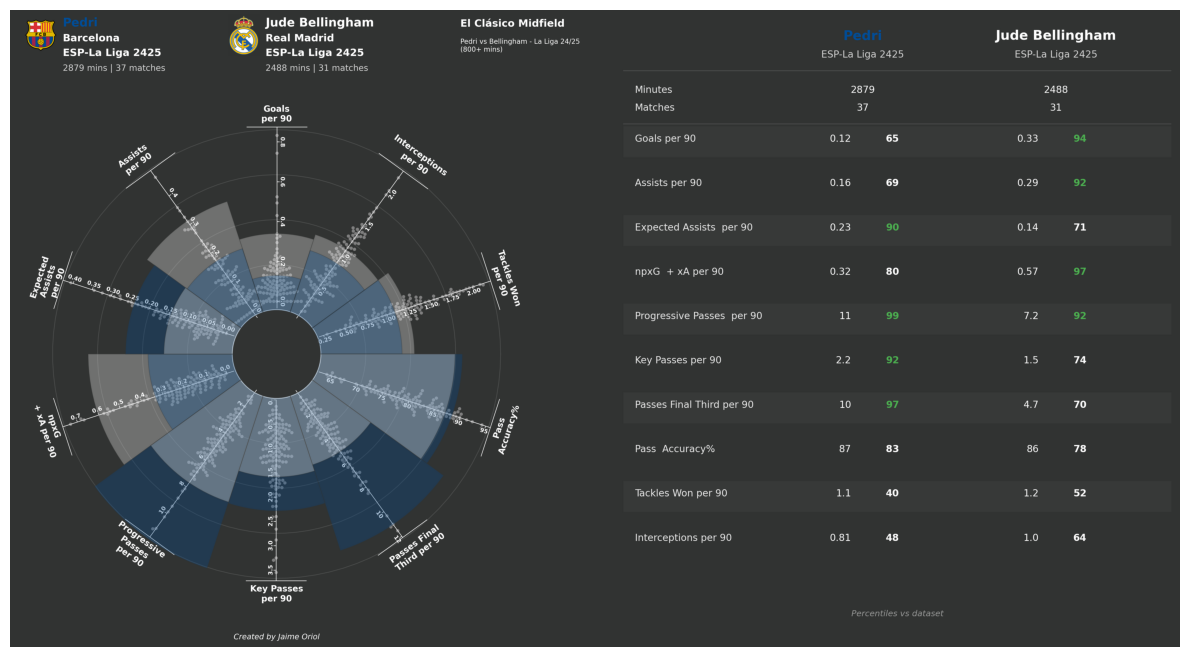


2. Individual + Stats:


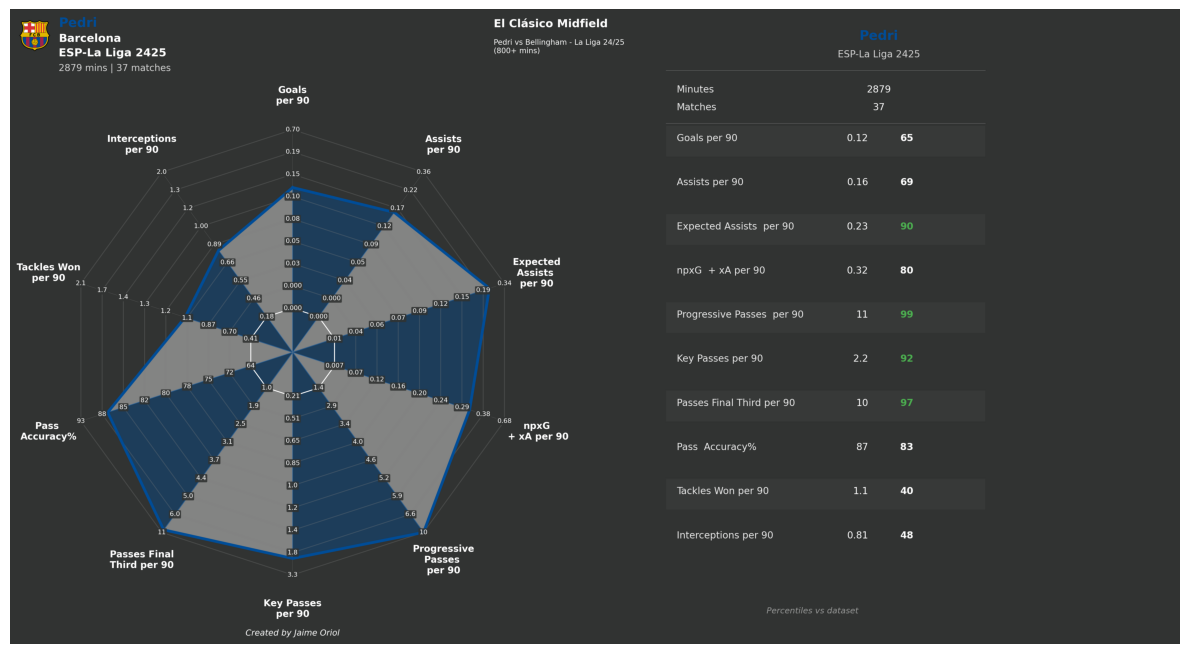


3. Traditional + Stats:


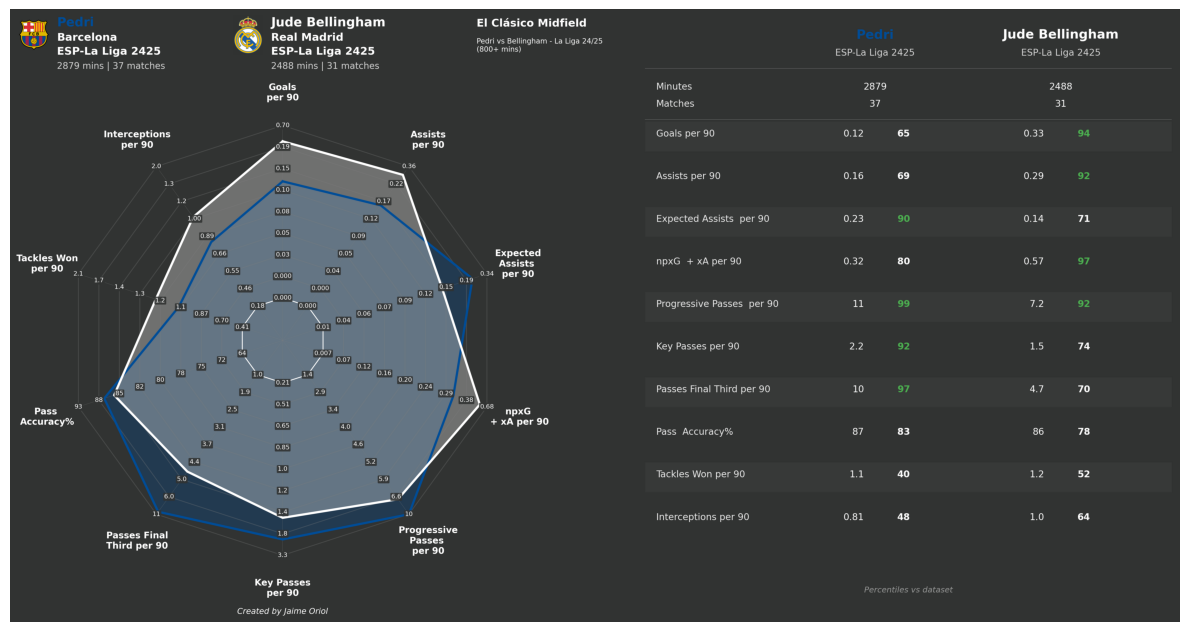


Imágenes combinadas generadas:
  - images/pedri_bellingham_laliga_individual_combined.png
  - images/pedri_bellingham_laliga_swarm_combined.png
  - images/pedri_bellingham_laliga_traditional_combined.png


In [16]:
from viz.swarm_radar import create_player_radar
from viz.stats_table import create_stats_table, combine_radar_and_table

if len(radar_metrics) == 10 and PLAYER_1_ID:
    
    # Gráfico 1: Swarm Radar (comparación)
    if PLAYER_2_ID:
        create_player_radar(
            df_data=df_final,
            player_1_id=PLAYER_1_ID,
            player_2_id=PLAYER_2_ID,
            metrics=radar_metrics,
            metric_titles=radar_titles,
            radar_title=RADAR_TITLE,
            radar_description=RADAR_DESCRIPTION,
            save_path=f"{SAVE_PATH_BASE}_swarm.png",
            team_colors=TEAM_COLORS,
            team_logos=team_logos,
            use_swarm=True,
            show_plot=False
        )
        
        # Tabla 1: Para Swarm Radar
        create_stats_table(
            df_data=df_final,
            player_1_id=PLAYER_1_ID,
            player_2_id=PLAYER_2_ID,
            metrics=radar_metrics,
            metric_titles=radar_titles,
            team_colors=TEAM_COLORS,
            save_path=f"{SAVE_PATH_BASE}_swarm_table.png",
            show_plot=False
        )
        
        # Combinada 1: Swarm Radar + Tabla
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}_swarm.png",
            table_path=f"{SAVE_PATH_BASE}_swarm_table.png",
            output_path=f"{SAVE_PATH_BASE}_swarm_combined.png"
        )
        
        # Mostrar Swarm Combined
        print("1. Swarm Radar + Stats:")
        img = Image.open(f"{SAVE_PATH_BASE}_swarm_combined.png")
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.imshow(img)
        ax.axis('off')
        plt.tight_layout()
        plt.show()
    
    # Gráfico 2: Radar individual (jugador 1)
    create_player_radar(
        df_data=df_final,
        player_1_id=PLAYER_1_ID,
        metrics=radar_metrics,
        metric_titles=radar_titles,
        radar_title=f"{RADAR_TITLE}",
        radar_description=RADAR_DESCRIPTION,
        save_path=f"{SAVE_PATH_BASE}_individual.png",
        team_colors=TEAM_COLORS,
        team_logos=team_logos,
        use_swarm=False,
        show_plot=False
    )
    
    # Tabla 2: Para Radar Individual
    create_stats_table(
        df_data=df_final,
        player_1_id=PLAYER_1_ID,
        metrics=radar_metrics,
        metric_titles=radar_titles,
        team_colors=TEAM_COLORS,
        save_path=f"{SAVE_PATH_BASE}_individual_table.png",
        show_plot=False
    )
    
    # Combinada 2: Individual Radar + Tabla
    combine_radar_and_table(
        radar_path=f"{SAVE_PATH_BASE}_individual.png",
        table_path=f"{SAVE_PATH_BASE}_individual_table.png",
        output_path=f"{SAVE_PATH_BASE}_individual_combined.png"
    )
    
    # Mostrar Individual Combined
    print("\n2. Individual + Stats:")
    img = Image.open(f"{SAVE_PATH_BASE}_individual_combined.png")
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(img)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Gráfico 3: Radar tradicional (comparación)
    if PLAYER_2_ID:
        create_player_radar(
            df_data=df_final,
            player_1_id=PLAYER_1_ID,
            player_2_id=PLAYER_2_ID,
            metrics=radar_metrics,
            metric_titles=radar_titles,
            radar_title=RADAR_TITLE,
            radar_description=RADAR_DESCRIPTION,
            save_path=f"{SAVE_PATH_BASE}_traditional.png",
            team_colors=TEAM_COLORS,
            team_logos=team_logos,
            use_swarm=False,
            show_plot=False
        )
        
        # Tabla 3: Para Radar Tradicional
        create_stats_table(
            df_data=df_final,
            player_1_id=PLAYER_1_ID,
            player_2_id=PLAYER_2_ID,
            metrics=radar_metrics,
            metric_titles=radar_titles,
            team_colors=TEAM_COLORS,
            save_path=f"{SAVE_PATH_BASE}_traditional_table.png",
            show_plot=False
        )
        
        # Combinada 3: Traditional Radar + Tabla
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}_traditional.png",
            table_path=f"{SAVE_PATH_BASE}_traditional_table.png",
            output_path=f"{SAVE_PATH_BASE}_traditional_combined.png"
        )
        
        # Mostrar Traditional Combined
        print("\n3. Traditional + Stats:")
        img = Image.open(f"{SAVE_PATH_BASE}_traditional_combined.png")
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.imshow(img)
        ax.axis('off')
        plt.tight_layout()
        plt.show()
    
    # Resumen de archivos generados
    print(f"\nImágenes combinadas generadas:")
    print(f"  - {SAVE_PATH_BASE}_individual_combined.png")
    if PLAYER_2_ID:
        print(f"  - {SAVE_PATH_BASE}_swarm_combined.png")
        print(f"  - {SAVE_PATH_BASE}_traditional_combined.png")
    
else:
    print("No se pueden generar gráficos: verificar métricas y IDs de jugadores")